In [2]:
import shap
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
# load JS visualization code to notebook
shap.initjs()

/Users/scai/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# load data

In [3]:
meta_file = '../data/E0022_P06_final_sample_map_filtered.txt'
data_file = '../data/protein/E0022_P06_log_transformed_median.tsv'
ic50_file = '../data/drug/ic50_processed_median.csv'
seed = 42

In [4]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

meta = pd.read_csv(meta_file, sep='\t')
ic50 = pd.read_csv(ic50_file)
ic50 = ic50.sort_values(by=['Dataset version'])
ic50 = ic50.drop_duplicates(
    ['Drug Id', 'Cell line name'], keep='last').sort_values(
    by=['Drug Id', 'Cell line name']).reset_index(drop=True)
min_cell_lines = 300
ic50_counts = ic50.groupby(['Drug Id']).size()
selected_drugs = ic50_counts[ic50_counts > min_cell_lines].index.values

# selected_drugs = [257]

ic50_selected = ic50[ic50['Drug Id'].isin(selected_drugs)]
ic50_selected_pivot = pd.pivot(ic50_selected[['Cell line name', 'Drug Id', 'IC50_norm']], index='Cell line name',
                               columns='Drug Id', values='IC50_norm').reset_index()

ic50_selected_pivot = ic50_selected_pivot.sort_values(by=['Cell line name']).reset_index(drop=True)

data_raw = pd.read_csv(data_file, sep='\t')
data_raw = data_raw.rename(columns={'Unnamed: 0': 'Automatic_MS_filename'})
data_raw_merge = pd.merge(data_raw, meta[['Automatic_MS_filename', 'Cell_line']])

data_sample = data_raw_merge.drop(['Automatic_MS_filename'],
                                  axis=1).groupby(['Cell_line']).agg(np.nanmean).reset_index()
data_sample = data_sample.sort_values(by=['Cell_line']).reset_index(drop=True)

cell_lines_train, cell_lines_test = train_test_split(sorted(data_sample['Cell_line'].unique()),
                                                     test_size=0.2,
                                                     random_state=seed)

ic50_selected_pivot_train = ic50_selected_pivot[
    ic50_selected_pivot['Cell line name'].isin(cell_lines_train)].reset_index(drop=True)
ic50_selected_pivot_test = ic50_selected_pivot[
    ic50_selected_pivot['Cell line name'].isin(cell_lines_test)].reset_index(drop=True)

num_of_proteins = data_sample.shape[1] - 1

data_sample_train = data_sample[data_sample['Cell_line'].isin(cell_lines_train)].reset_index(drop=True)
data_sample_test = data_sample[data_sample['Cell_line'].isin(cell_lines_test)].reset_index(drop=True)

merged_df_train = pd.merge(data_sample_train, ic50_selected_pivot_train, left_on=['Cell_line'],
                           right_on=['Cell line name']).drop(['Cell line name'], axis=1)
merged_df_test = pd.merge(data_sample_test, ic50_selected_pivot_test, left_on=['Cell_line'],
                          right_on=['Cell line name']).drop(['Cell line name'], axis=1)

train_df = merged_df_train.iloc[:, 1:(num_of_proteins + 1)]
train_ic50 = merged_df_train.iloc[:, (num_of_proteins + 1):]
test_ic50 = merged_df_test.iloc[:, (num_of_proteins + 1):]
test_df = merged_df_test.iloc[:, 1:(num_of_proteins + 1)]

# gradient explainer

In [46]:
shap_values = pickle.load(open("../work_dirs/shap/gradient_shap.pkl", "rb"))
index = pickle.load(open("../work_dirs/shap/gradient_indexes.pkl", "rb"))

In [104]:
index

array([[131, 191],
       [191, 131],
       [111, 191],
       [286, 131],
       [191, 111],
       [131,  20],
       [111, 131],
       [111, 125],
       [131, 168],
       [286, 131],
       [191, 125],
       [111, 191],
       [191, 131],
       [191, 125],
       [131, 191],
       [125,  89],
       [191, 162],
       [191, 111],
       [286, 131],
       [286, 131],
       [131, 125],
       [191, 194],
       [131, 191],
       [111, 191],
       [191, 131],
       [191, 131],
       [131, 191],
       [131, 125],
       [111, 131],
       [131, 286],
       [131,  78],
       [ 20, 131],
       [ 89, 125],
       [131, 191],
       [131,  20],
       [ 78, 125],
       [131,  78],
       [286, 131],
       [286, 312],
       [131, 286],
       [131,  75],
       [331, 125],
       [191, 195],
       [125, 195],
       [191, 131],
       [191, 131],
       [131, 125],
       [131, 111],
       [191, 131],
       [131, 191],
       [194, 131],
       [ 89, 168],
       [191,

In [188]:
target = 286
# target = 262

In [189]:
drug_index = np.argwhere(index == target)

In [190]:
res = []
for i in drug_index:
    res.append(shap_values[i[1]][i[0],:])
res = np.array(res)

In [191]:
res.shape

(40, 4020)

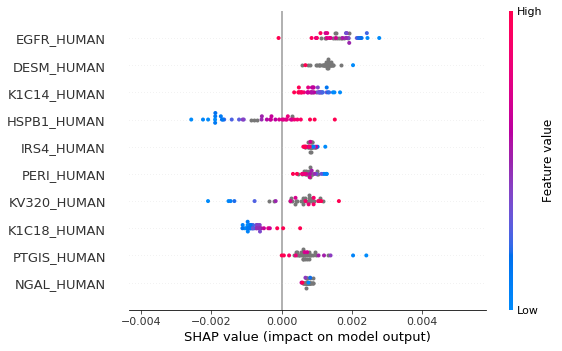

In [193]:
shap.summary_plot(res, test_df.iloc[drug_index[:, 0], :], max_display=10)

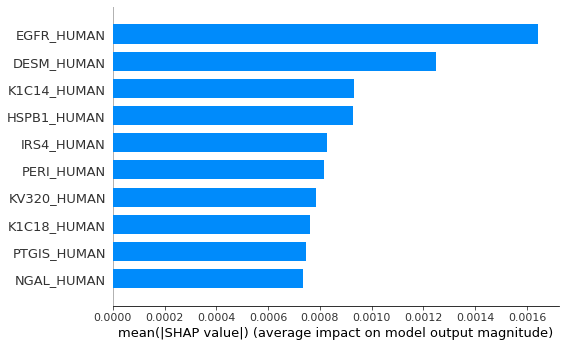

In [194]:
shap.summary_plot(res,
                  test_df.iloc[drug_index[:, 0], :],
                  max_display=10,
                  plot_type='bar')

In [198]:
test_ic50.iloc[:,target].name

1114

In [10]:
test_ic50.columns.get_loc(1)

0

# deep explainer

In [5]:
shap_values = pickle.load(open("../work_dirs/shap/deep_shap.pkl", "rb"))
target = 333

In [6]:
shap_values_target = shap_values[target]

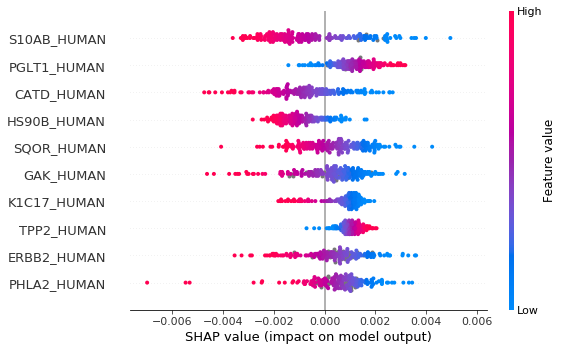

In [7]:
shap.summary_plot(shap_values_target, test_df, max_display=10)

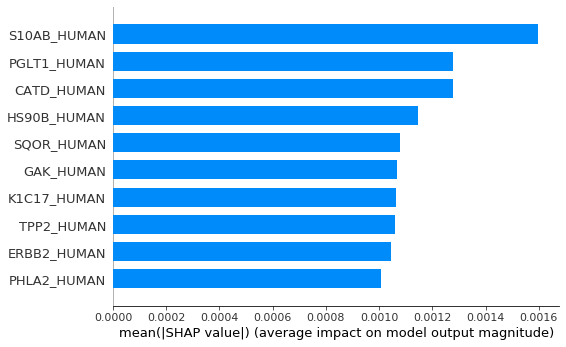

In [8]:
shap.summary_plot(shap_values_target, test_df, max_display=10, plot_type='bar')